In [138]:
import warnings
warnings.filterwarnings('ignore')

In [150]:
import pandas as pd
from neuralprophet import NeuralProphet
import plotly.graph_objects as go
import pickle

In [140]:
df = pd.read_csv('./dataset/sensors_202205192146.csv', parse_dates=['created_at'], index_col='created_at')


cols = ['temperature']
df = df[cols].astype(float)


In [141]:
freq = '1min'

In [142]:
df = df.resample(freq).mean().interpolate()

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7066 entries, 2022-05-15 00:01:00 to 2022-05-19 21:46:00
Freq: T
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7066 non-null   float64
dtypes: float64(1)
memory usage: 110.4 KB


In [144]:
df = df.reset_index()

In [145]:
new_column = df[['created_at', 'temperature']] 
new_column.dropna(inplace=True)
new_column.columns = ['ds', 'y'] 

In [146]:
n = NeuralProphet()
model = n.fit(new_column, freq=freq )

INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 112


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.88E-02, min: 2.85E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 8.95E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.76E-02
Epoch[112/112]: 100%|██████████| 112/112 [01:13<00:00,  1.52it/s, SmoothL1Loss=0.00666, MAE=0.86, RMSE=1.13, RegLoss=0] 


In [147]:
future = n.make_future_dataframe(new_column, periods=60*24,n_historic_predictions=True)
forecast = n.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min
INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min
INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 1min


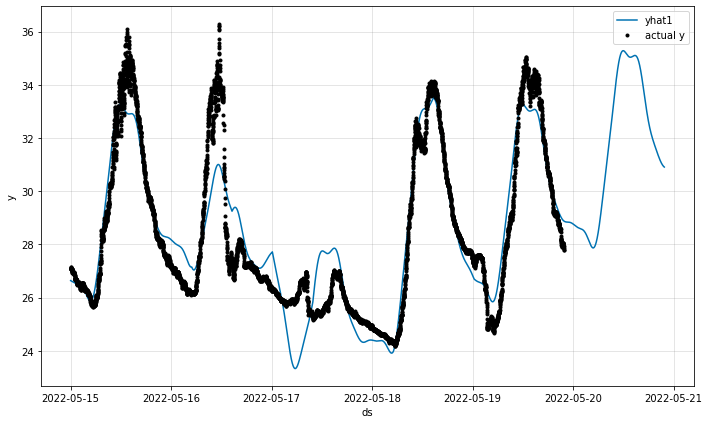

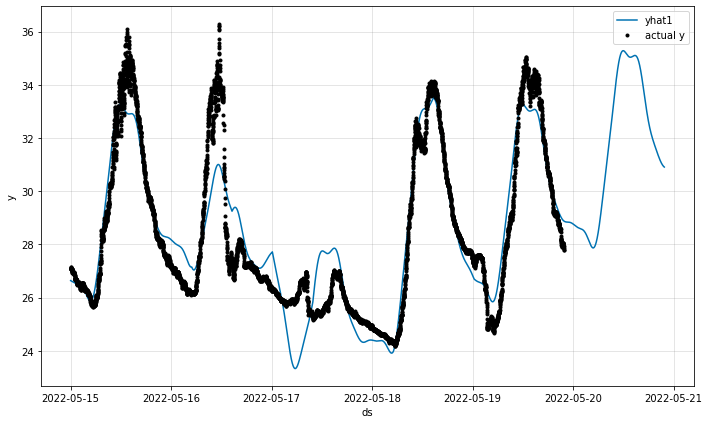

In [148]:
n.plot(forecast)

In [149]:
trace1 = go.Scatter(
    x = new_column['ds'].values,
    y = new_column['y'].values,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast['ds'].values,
    y = forecast['yhat1'].values,
    mode = 'lines',
    name = 'Prediction'
)

layout = go.Layout(
    title = "temp",
    xaxis = {'title' : "datetime"},
    yaxis = {'title' : "temperature"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [151]:
with open('./models/neuralprophet_model.pkl', "wb") as f:
    pickle.dump(n, f)